# Arko Holdings Rent Prediction

## 1. Data Exploration

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import seaborn as sns

from sklearn import preprocessing

import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.width', 100)

In [5]:
df = pd.read_csv('House_Rent_Dataset.csv')

In [6]:
df.shape

(4746, 12)

In [7]:
df.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


### Clean the Data

In [11]:
# Check for null values
df.isna().sum()

Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64

There are no null values in df

In [13]:
def refine(df):
    df.columns = df.columns.str.strip()
    print("Column names striped")
    df = df.drop_duplicates()
    print("Duplicates dropped")
    df.columns = df.columns.str.lower() #transform Pascal || Upper Case to Lower Case
    df.columns = df.columns.str.replace(' ','_')
    print("Case transformed to lower")
    categorical_df = df.select_dtypes(['object'])
    df[categorical_df.columns] = categorical_df.apply(lambda x: x.str.strip())
    print("Categorical features striped")
    return df

In [14]:
df.shape

(4746, 12)

In [15]:
data = refine(df)

Column names striped
Duplicates dropped
Case transformed to lower
Categorical features striped


In [16]:
data.columns

Index(['posted_on', 'bhk', 'rent', 'size', 'floor', 'area_type', 'area_locality', 'city',
       'furnishing_status', 'tenant_preferred', 'bathroom', 'point_of_contact'],
      dtype='object')

In [17]:
# Split the floor column
data = data.join(data['floor'].str.split(' out of ', n=1, expand=True).rename(columns={0:'floor_level', 1:'total_floor'}))
data['floor_level'] = data.apply(lambda x: 0 if x['floor_level'] =='Ground' \
                               else ( -1 if x['floor_level'] =='Lower Basement' else (x['total_floor'])), axis=1)
print("Status: Changed 'Ground'=0, 'Lower Basement'=-1, Rest = total_floors")
data.drop(['floor'], axis=1,inplace=True)

Status: Changed 'Ground'=0, 'Lower Basement'=-1, Rest = total_floors


In [18]:
# dropna
data = data.dropna()

# change to correct data type
data['floor_level'] = data['floor_level'].astype('int64')
data['total_floor'] = data['total_floor'].astype('int64')

In [19]:
data['posted_on'] = pd.to_datetime(data["posted_on"],errors='coerce')

In [20]:
# Check for value counts
categorical_features = data.select_dtypes(include = [object])
for col in categorical_features.columns:
    value_count = data.reset_index().groupby([col]).size().to_frame('count')
    value_count['percentage (%)'] = value_count['count'].div(sum(value_count['count'])).mul(100)
    value_count = value_count.sort_values(by=['percentage (%)'], ascending=False)
    print(f"Value counts for {col}:")
    display(value_count)

Value counts for area_type:


,count,percentage (%)
area_type,,
Super Area,2444,51.539435
Carpet Area,2296,48.418389
Built Area,2,0.042176


Value counts for area_locality:


,count,percentage (%)
area_locality,,
Bandra West,37,0.780261
Gachibowli,29,0.611556
Electronic City,24,0.506116
Velachery,22,0.463939
"Miyapur, NH 9",22,0.463939
...,...,...
Mandirtala,1,0.021088
"Mandakini Enclave, Alaknanda",1,0.021088
"DDA Akshardham Apartments, DS 19",1,0.021088


Value counts for city:


,count,percentage (%)
city,,
Mumbai,972,20.497680
Chennai,891,18.789540
Bangalore,886,18.684100
Hyderabad,866,18.262337
Delhi,603,12.716154
Kolkata,524,11.050190


Value counts for furnishing_status:


,count,percentage (%)
furnishing_status,,
Semi-Furnished,2250,47.448334
Unfurnished,1814,38.253901
Furnished,678,14.297765


Value counts for tenant_preferred:


,count,percentage (%)
tenant_preferred,,
Bachelors/Family,3441,72.564319
Bachelors,830,17.503163
Family,471,9.932518


Value counts for point_of_contact:


,count,percentage (%)
point_of_contact,,
Contact Owner,3212,67.735133
Contact Agent,1529,32.243779
Contact Builder,1,0.021088


## 2. Exploratory Data Analysis (EDA)

#### Univariate Analysis

**Visualization**

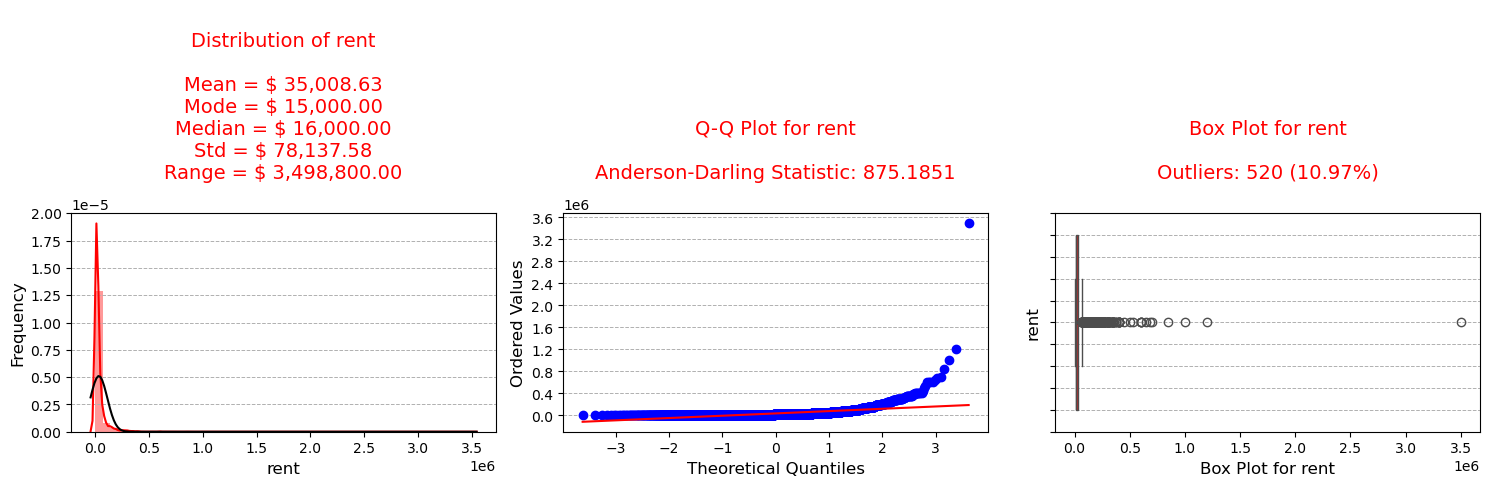

In [32]:
from scipy.stats import anderson
import scipy.stats as stats
from matplotlib.ticker import MaxNLocator

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Dist Plot for Rent
sns.distplot(data['rent'], kde=True, ax=axes[0], color='red', fit=stats.norm, fit_kws={"color": "black"})
axes[0].set_xlabel('rent', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
axes[0].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))
axes[0].set_title(f"\n"
                  f"Distribution of rent\n"
                  f"\n"
                  f"Mean = $ {data['rent'].mean():,.2f}\n"
                  f"Mode = $ {data['rent'].mode().iloc[0]:,.2f}\n"
                  f"Median = $ {data['rent'].median():,.2f}\n"
                  f"Std = $ {data['rent'].std():,.2f}\n"
                  f"Range = $ {np.ptp(data['rent']):,.2f}\n", 
                  fontsize=14, y=1.02, color='red')

# Q-Q Plot for Rent
stats.probplot(data['rent'], dist="norm", plot=axes[1])
axes[1].set_xlabel('Theoretical Quantiles', fontsize=12)
axes[1].set_ylabel('Ordered Values', fontsize=12)
axes[1].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
axes[1].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))
axes[1].set_title(f"\n"
                  f"Q-Q Plot for rent\n"
                  f"\n"
                  f"Anderson-Darling Statistic: {anderson(data['rent']).statistic:.4f}\n", 
                  fontsize=14, y=1.02, color='red')

# Box Plot for Rent
# Calculate and add information about outliers
Q1 = data['rent'].quantile(0.25)
Q3 = data['rent'].quantile(0.75)
IQR = Q3 - Q1
iqr_outliers = (data['rent'] < Q1 - 1.5 * IQR) | (data['rent'] > Q3 + 1.5 * IQR)
percent_iqr_outliers = (sum(iqr_outliers) / len(data)) * 100

sns.boxplot(x='rent', data=data, ax=axes[2], color='red')
axes[2].set_ylabel('rent', fontsize=12)
axes[2].set_xlabel('Box Plot for rent', fontsize=12)
axes[2].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
axes[2].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))
axes[2].set_title(f"\n"
                  f"Box Plot for rent\n"
                  f"\n"
                  f'Outliers: {sum(iqr_outliers)} ({percent_iqr_outliers:.2f}%)\n', 
                  fontsize=14, y=1.02, color='red')

plt.tight_layout()
plt.show()

The rent distribution is highly right skewed. To normalize it, we will apply log transformation

In [35]:
data['rent'] = np.log1p(data['rent'])


 mu = 9.88 and sigma = 0.94



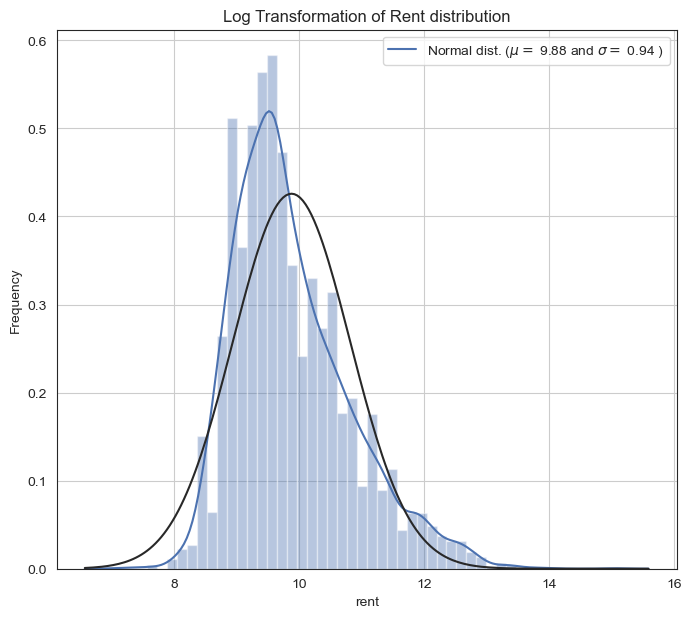

In [53]:
from scipy.stats import norm

sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
sns.distplot(data['rent'] , fit=norm, color="b");

(mu, sigma) = norm.fit(data['rent'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.grid(True)
ax.set(ylabel="Frequency")
ax.set(xlabel="rent")
ax.set(title="Log Transformation of Rent distribution")

plt.show()

In [63]:
def create_stripplot(df, column="rent", figsize=(20, 6), color_palette=None):
    if color_palette is None:
        color_palette = sns.color_palette("husl", 3)
        color_palette1 = sns.set_palette(sns.color_palette("inferno"))
        color_palette2 = sns.set_color_codes(palette='dark')
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    for ax in axs:
        sns.stripplot(y=df[column], ax=ax, color=color_palette[1], size=3, alpha=0.7,
                      linewidth=0.1, edgecolor="black")
        mean_value = np.mean(df[column])
        median_value = np.median(df[column])
        
        ax.axhline(mean_value, linestyle="--", color=color_palette[0], label=f"Mean: {mean_value:.2f}", linewidth=1)
        ax.axhline(median_value, linestyle="-", color=color_palette2, label=f"Median: {median_value:.2f}", linewidth=1)
        
        ax.set_ylabel(column)
        ax.tick_params(axis='y', which='both', left=True, right=False)
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        
        sns.despine(ax=ax, left=False, bottom=True)
        ax.grid(axis='y', linewidth=0.2)

        ax.legend()

    axs[0].set_title(f"{column} Distribution (Linear Scale)")
    axs[1].set(yscale="log", title=f"{column} Distribution (Logarithmic Scale)")

    plt.tight_layout()
    plt.show()

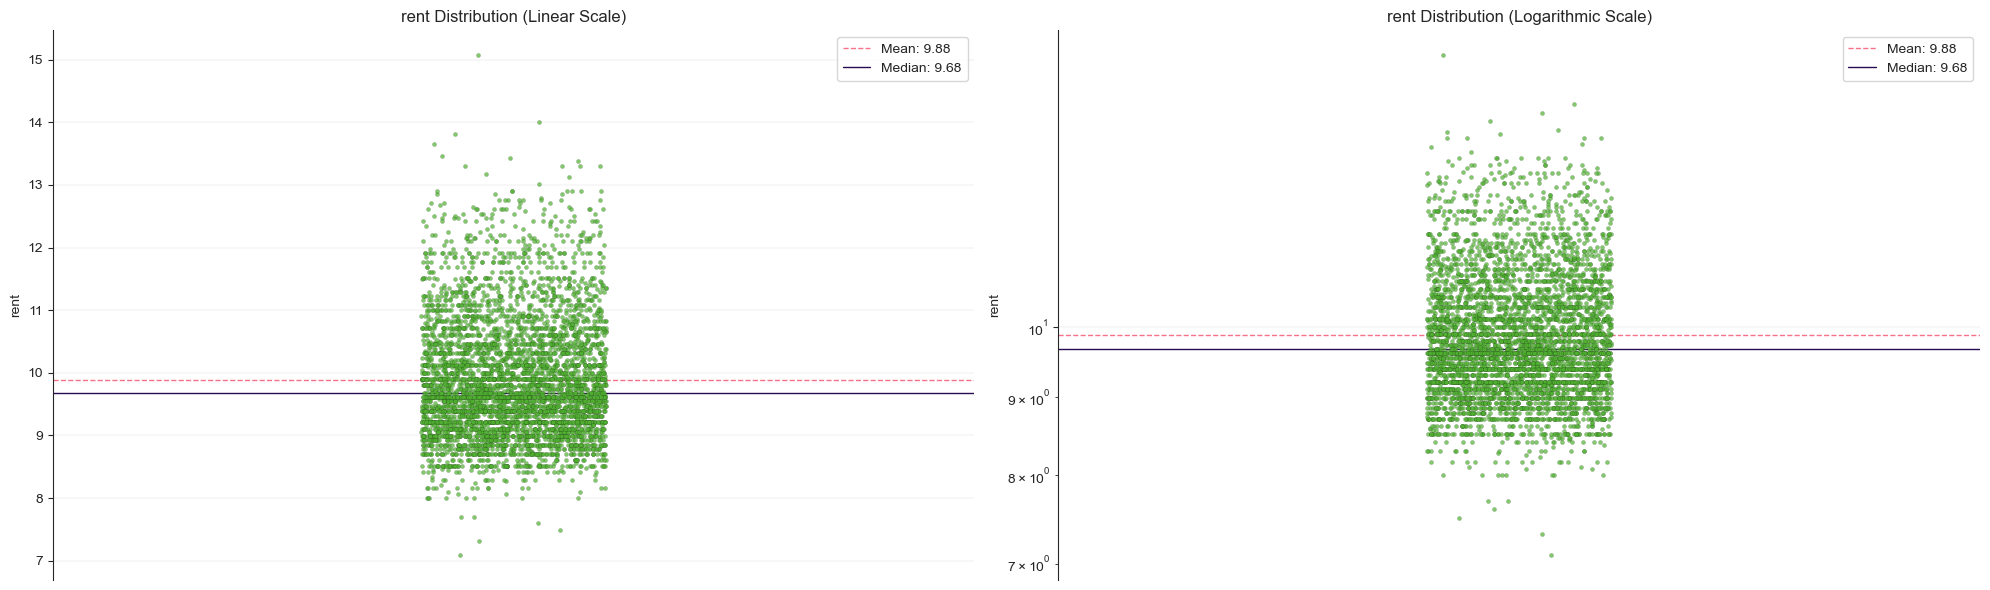

In [65]:
create_stripplot(data, column="rent")

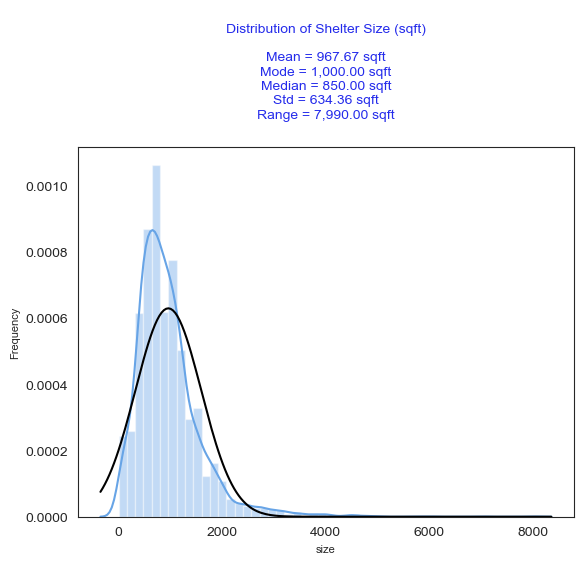

In [79]:
# Size Distribution
sns.distplot(data['size'], kde=True, color='#67A4E6', fit=stats.norm, fit_kws={"color": "black"})
plt.xlabel('size', fontsize=8)
plt.ylabel('Frequency', fontsize=8)
plt.title(f"\nDistribution of Shelter Size (sqft)\n"
          f"\n"
          f"Mean = {data['size'].mean():,.2f} sqft\n"
          f"Mode = {data['size'].mode().iloc[0]:,.2f} sqft\n"
          f"Median = {data['size'].median():,.2f} sqft\n"
          f"Std = {data['size'].std():,.2f} sqft\n"
          f"Range = {np.ptp(data['size']):,.2f} sqft\n", 
          fontsize=10, y=1.02, color='#252CEB')
plt.show()

In [71]:
data = data.drop(['area_locality'], axis=1)

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4742 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   posted_on          4742 non-null   datetime64[ns]
 1   bhk                4742 non-null   int64         
 2   rent               4742 non-null   float64       
 3   size               4742 non-null   int64         
 4   area_type          4742 non-null   object        
 5   city               4742 non-null   object        
 6   furnishing_status  4742 non-null   object        
 7   tenant_preferred   4742 non-null   object        
 8   bathroom           4742 non-null   int64         
 9   point_of_contact   4742 non-null   object        
 10  floor_level        4742 non-null   int64         
 11  total_floor        4742 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(5)
memory usage: 481.6+ KB


In [103]:
categorical_features = categorical_features.drop(columns=['area_locality'])
categorical_features.columns

Index(['area_type', 'city', 'furnishing_status', 'tenant_preferred', 'point_of_contact'], dtype='object')

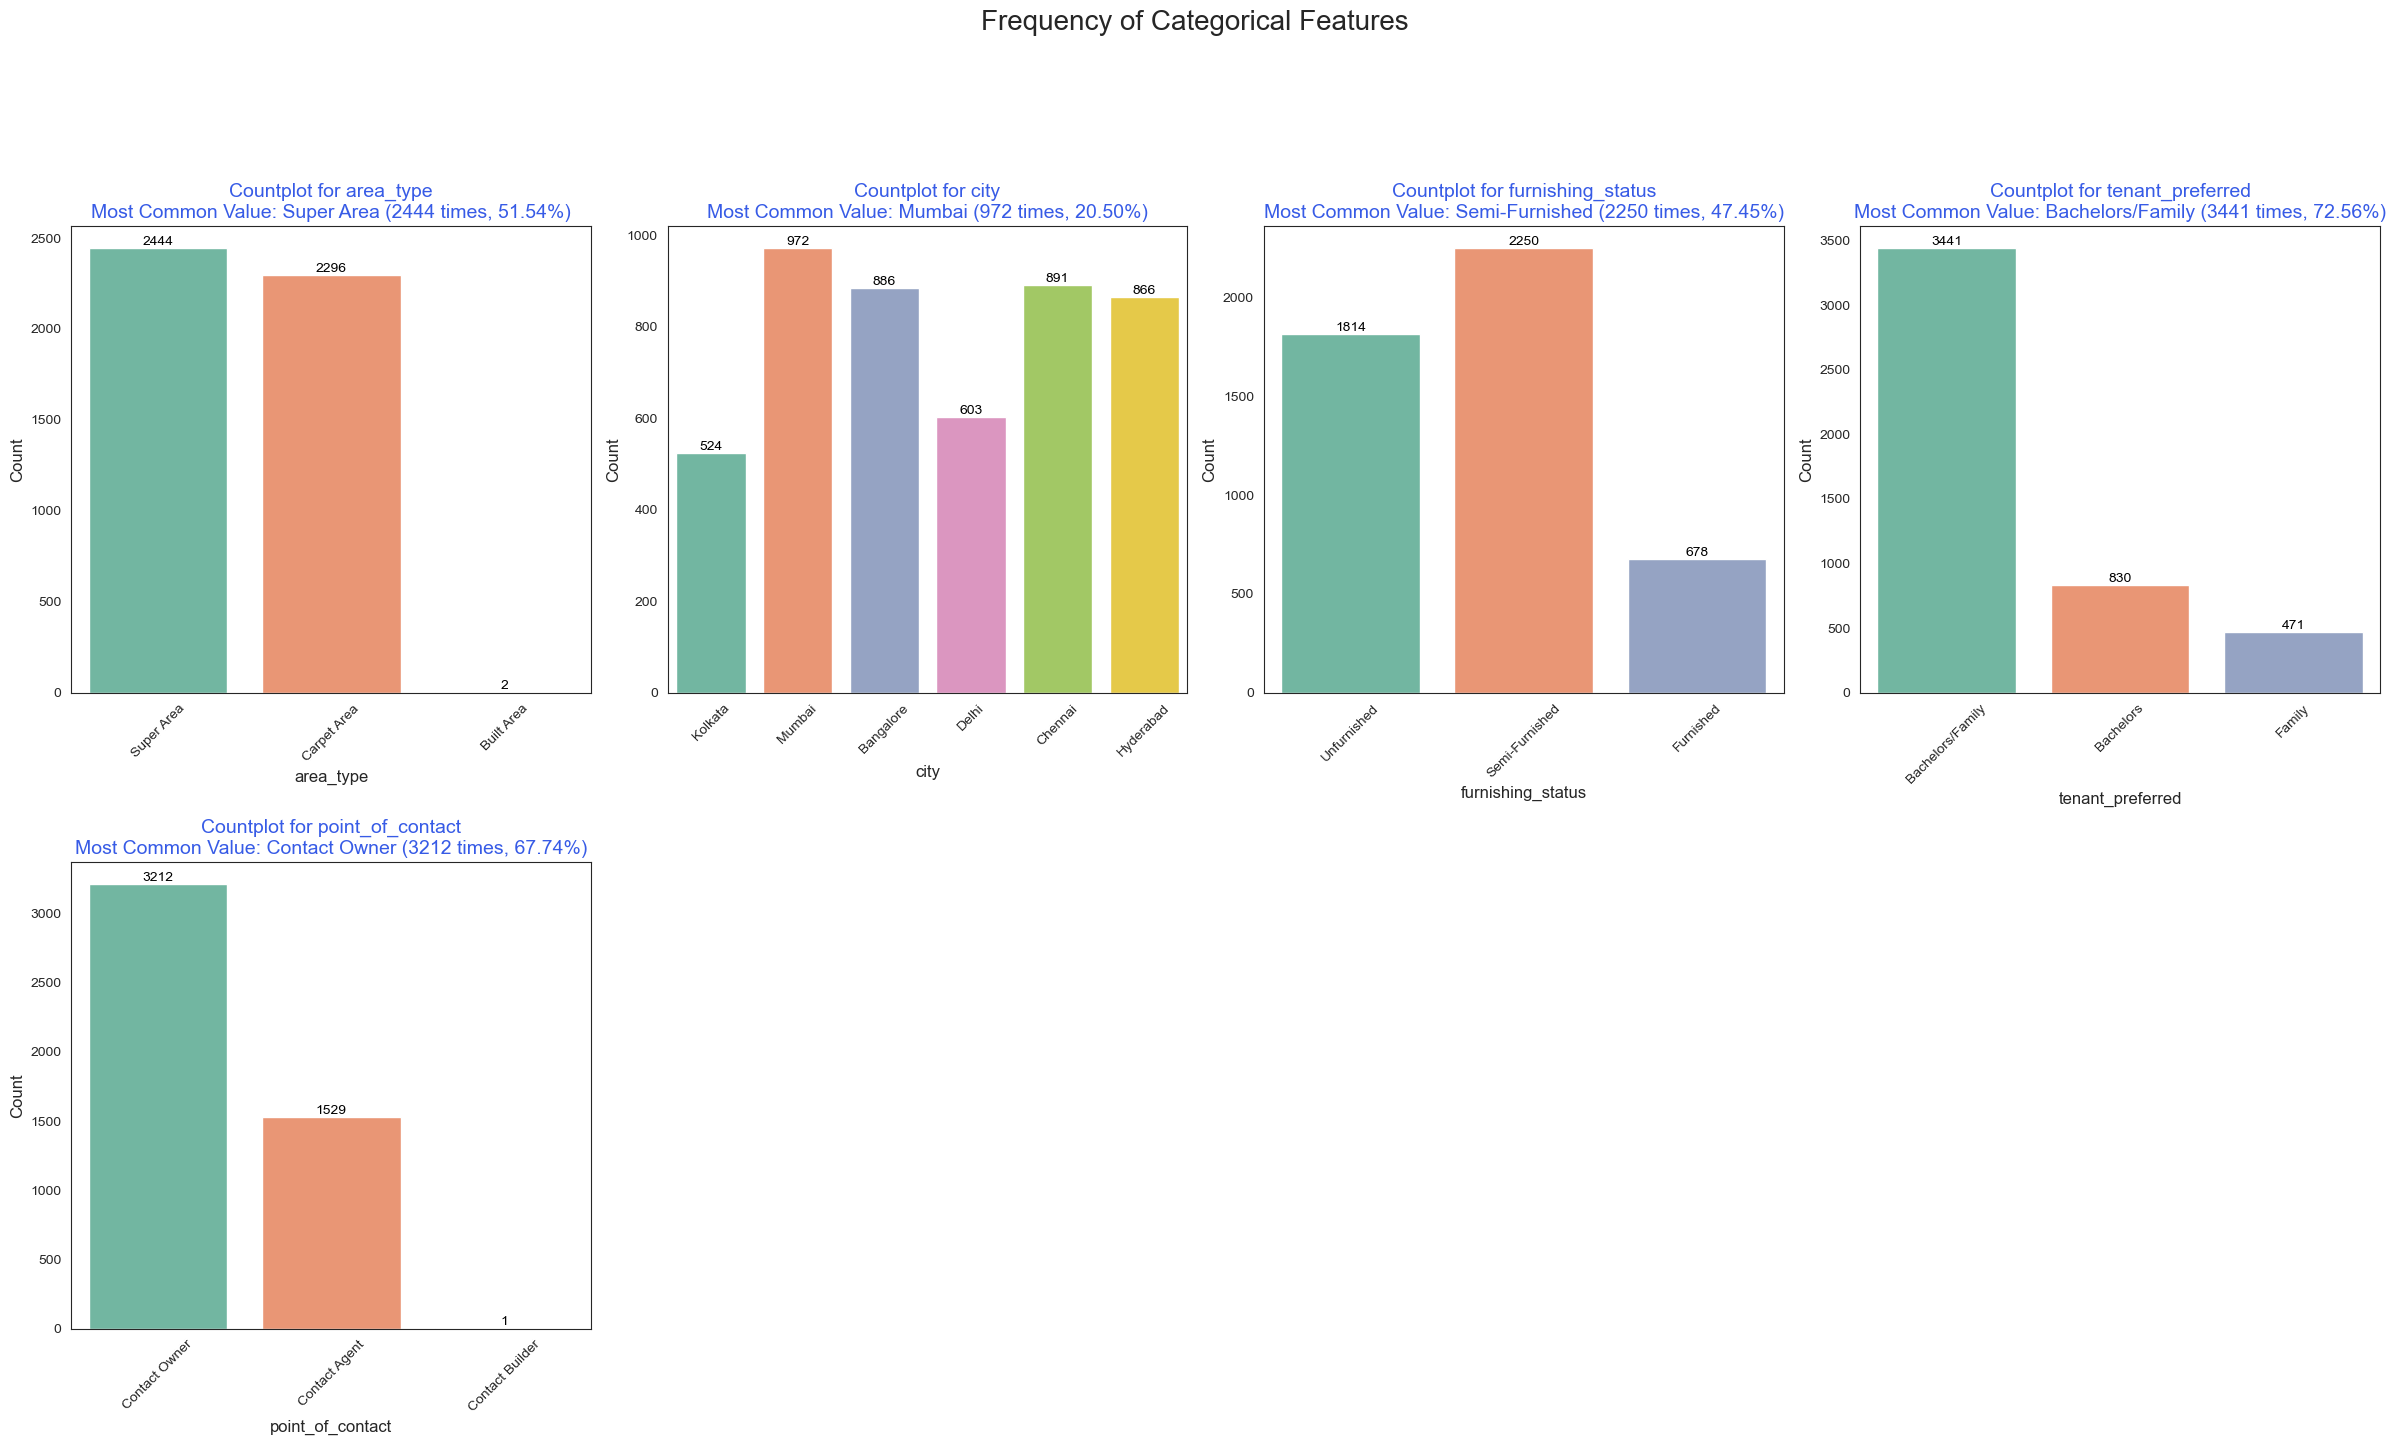

In [125]:
num_rows = (len(categorical_features.columns) + 3) // 4
fig, axes = plt.subplots(num_rows, 4, figsize=(24, 6 * num_rows))
axes = axes.ravel()
fig.suptitle("Frequency of Categorical Features", fontsize=20, y=1.2)

for i, col in enumerate(categorical_features.columns):   
    ax = axes[i]
    sns.countplot(x=col, data=categorical_features, ax=ax, palette='Set2')
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    
    vc = categorical_features[col].value_counts()
    if not vc.empty:
        values = vc.index[0]
        counts = vc.values[0]
        ax.set_title(f'Countplot for {col}\n'
                     f"Most Common Value: {values} ({counts} times, {counts / len(categorical_features) * 100:,.2f}%)", 
                     fontsize=14, color='#375BE6')
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', fontsize=10, color='black')
    ax.tick_params(axis='x', rotation=45)

for i in range(len(categorical_features.columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.subplots_adjust(top=1.02)
plt.show()

In [127]:
num_cols = ['bhk', 'bathroom', 'floor_level', 'total_floor']

In [137]:
def hist(df, x, ax, main_color, meanline=True, mean_color='#FF7F0E'):
    sns.histplot(data=df, x=x, ax=ax, color=main_color, linewidth=3.0, edgecolor="black", bins=50)
    
    if meanline:
        mean_value = np.mean(df[x])
        ax.axvline(mean_value, linestyle="--", linewidth=2, label=f"Mean: {round(mean_value, 2)}", color=mean_color)
        ax.legend(fontsize=8)
    
    ax.set_ylabel("Frequency", fontsize=12)
    ax.set_xlabel(x, fontsize=12)
    ax.set_title(f"{x} Distribution", fontsize=10)
    
    ax.tick_params(axis='y', which='both', left=False, right=False)
    sns.despine(ax=ax, left=True)
    ax.grid(axis='y', linewidth=0.4)

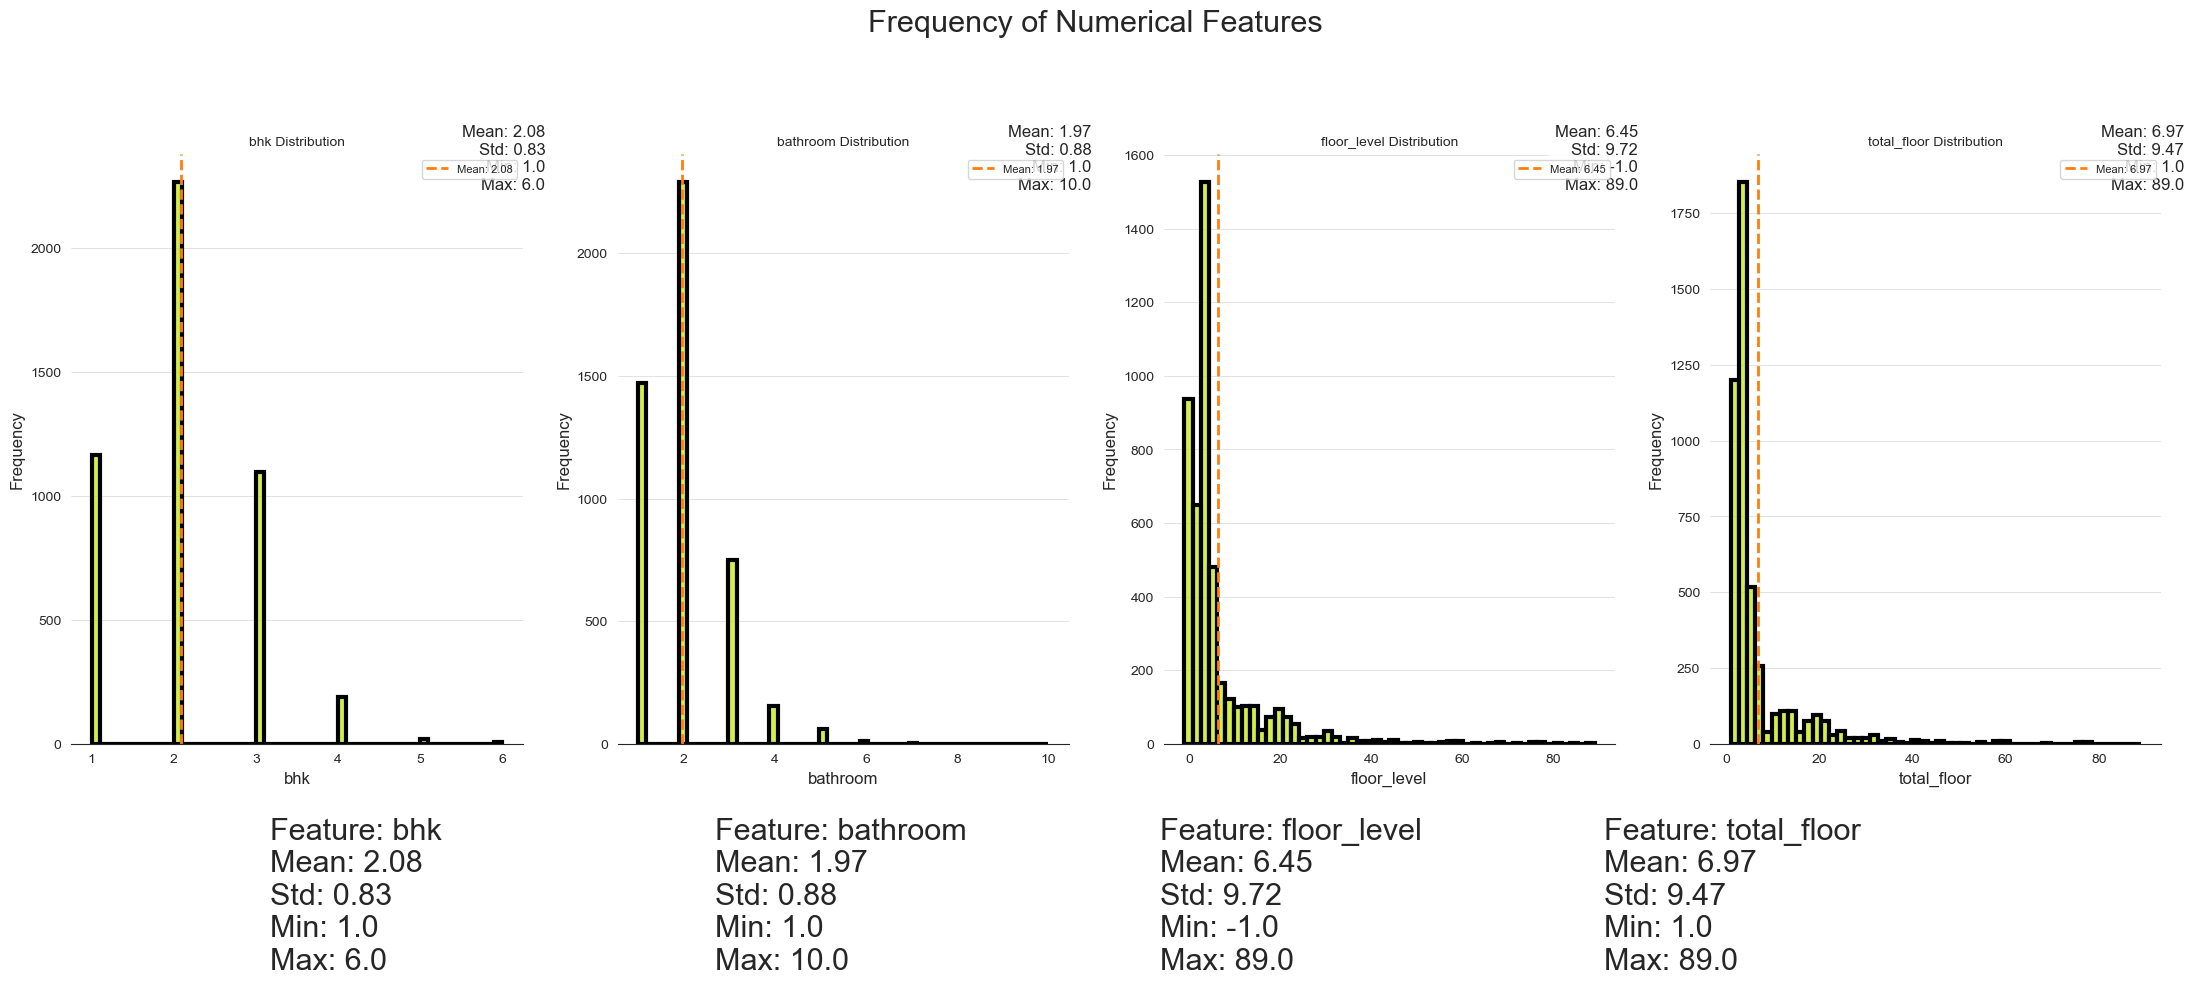

In [145]:
fig, axes = plt.subplots(1, 4, figsize=(22, 8))
axes = axes.ravel()
fig.suptitle("Frequency of Numerical Features", y=1.02, fontsize=22)

for i, col in enumerate(num_cols):
    is_not_date = (col != "Posted On")
    hist(data, col, axes[i], '#C7E613', meanline=is_not_date)
    
    stats = data[col].describe().round(2)
    stats_text = f"Mean: {stats['mean']}\nStd: {stats['std']}\nMin: {stats['min']}\nMax: {stats['max']}"
    axes[i].text(1.05, 1.05, stats_text, transform=axes[i].transAxes, 
                 verticalalignment='top', horizontalalignment='right',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                 fontsize=12)
    figure_text = f"Feature: {col}\nMean: {stats['mean']}\nStd: {stats['std']}\nMin: {stats['min']}\nMax: {stats['max']}"
    fig.text(axes[i].get_position().x0, axes[i].get_position().y0 - 0.1, 
             figure_text, fontsize=22, ha='left', va='top')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Bivariate Analysis

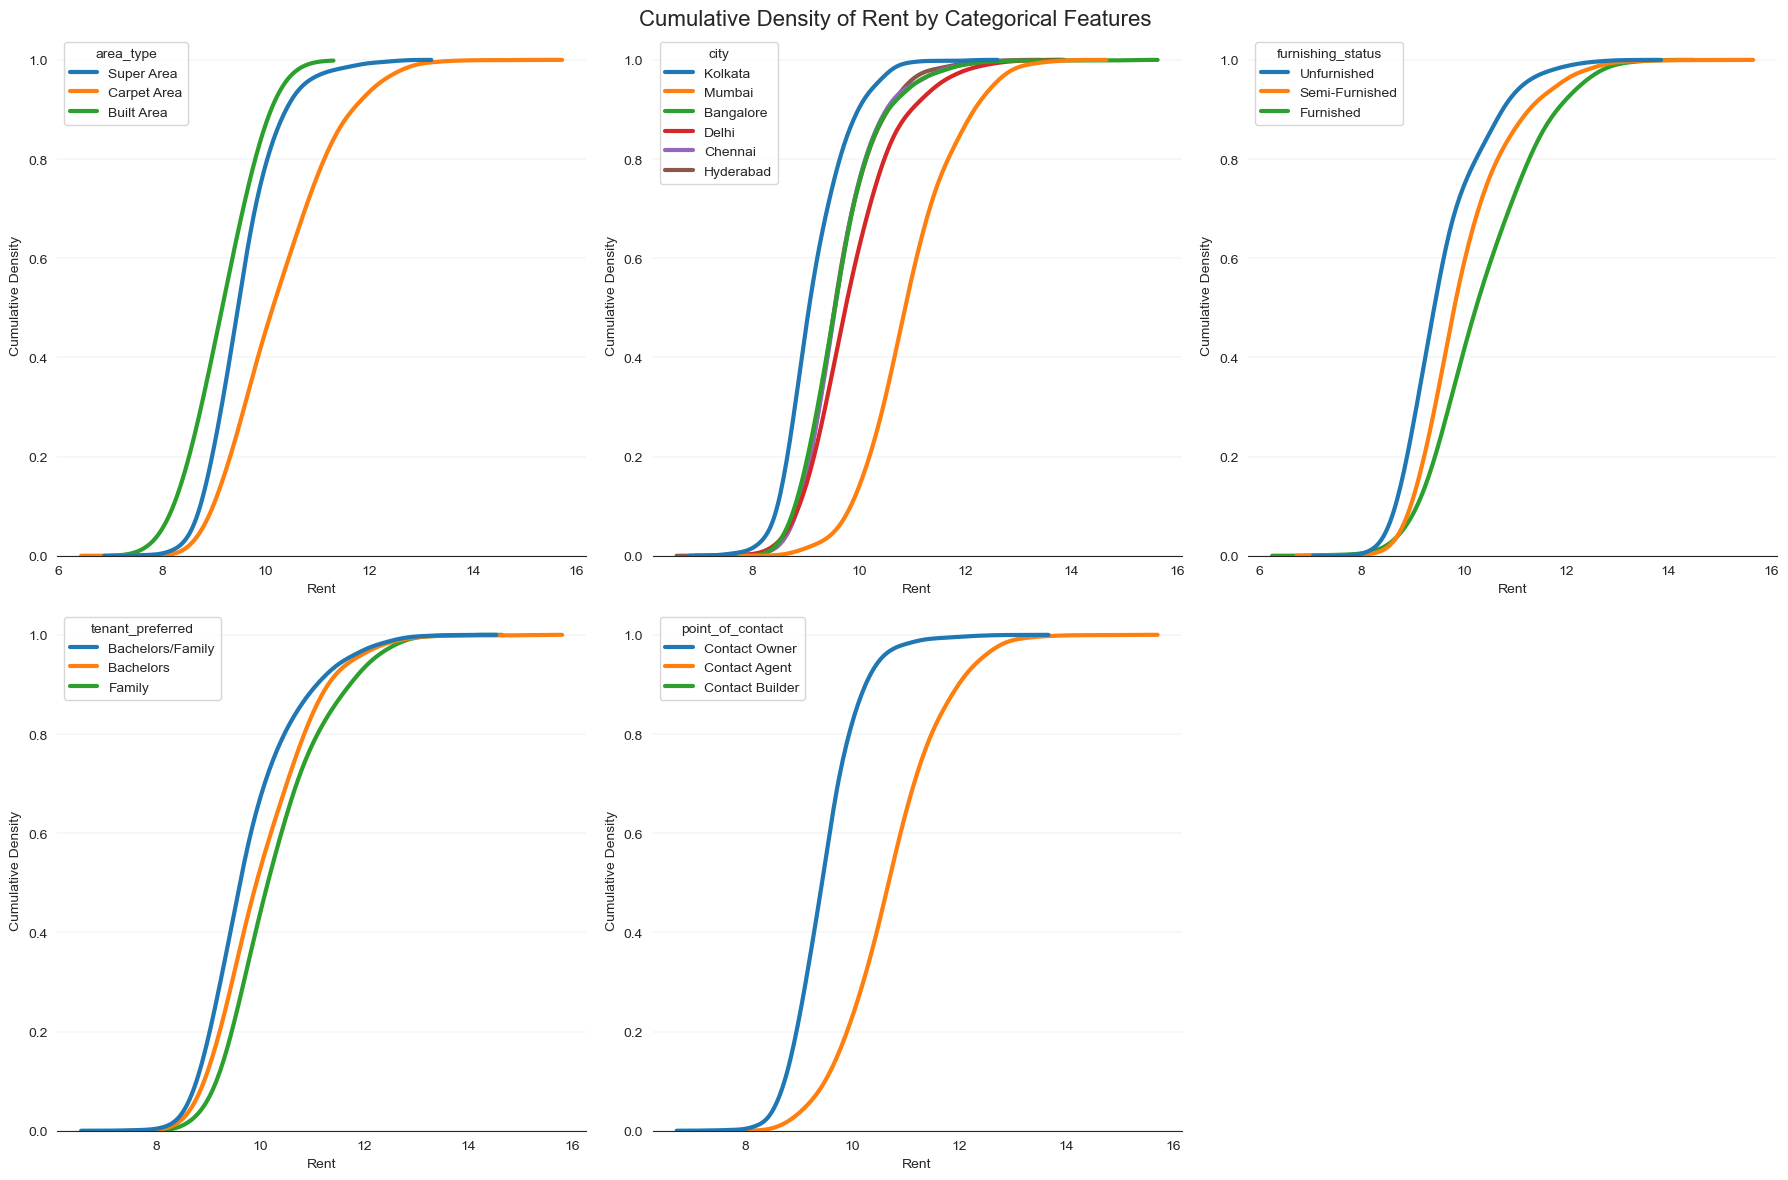

In [115]:
custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs=axs.flatten()
for i, col in enumerate(categorical_features.columns):
    ax = axs[i]
    sns.kdeplot(data=data, x='rent', hue=col,
                palette=custom_palette,
                cumulative=True, ax=ax, warn_singular=False, linewidth=3, common_norm=False)
    ax.set(xlabel="Rent", ylabel="Cumulative Density")
    sns.despine(ax=ax, left=True)
    ax.grid(axis='y', linewidth=0.2)
    ax.tick_params(
        axis='y',          
        which='both',      
        left=False,      
        right=False,         
        labelleft=True)
    
for j in range(len(categorical_features.columns), len(axs)):
    fig.delaxes(axs[j])

fig.suptitle("Cumulative Density of Rent by Categorical Features", fontsize=16)
plt.tight_layout()
plt.show()

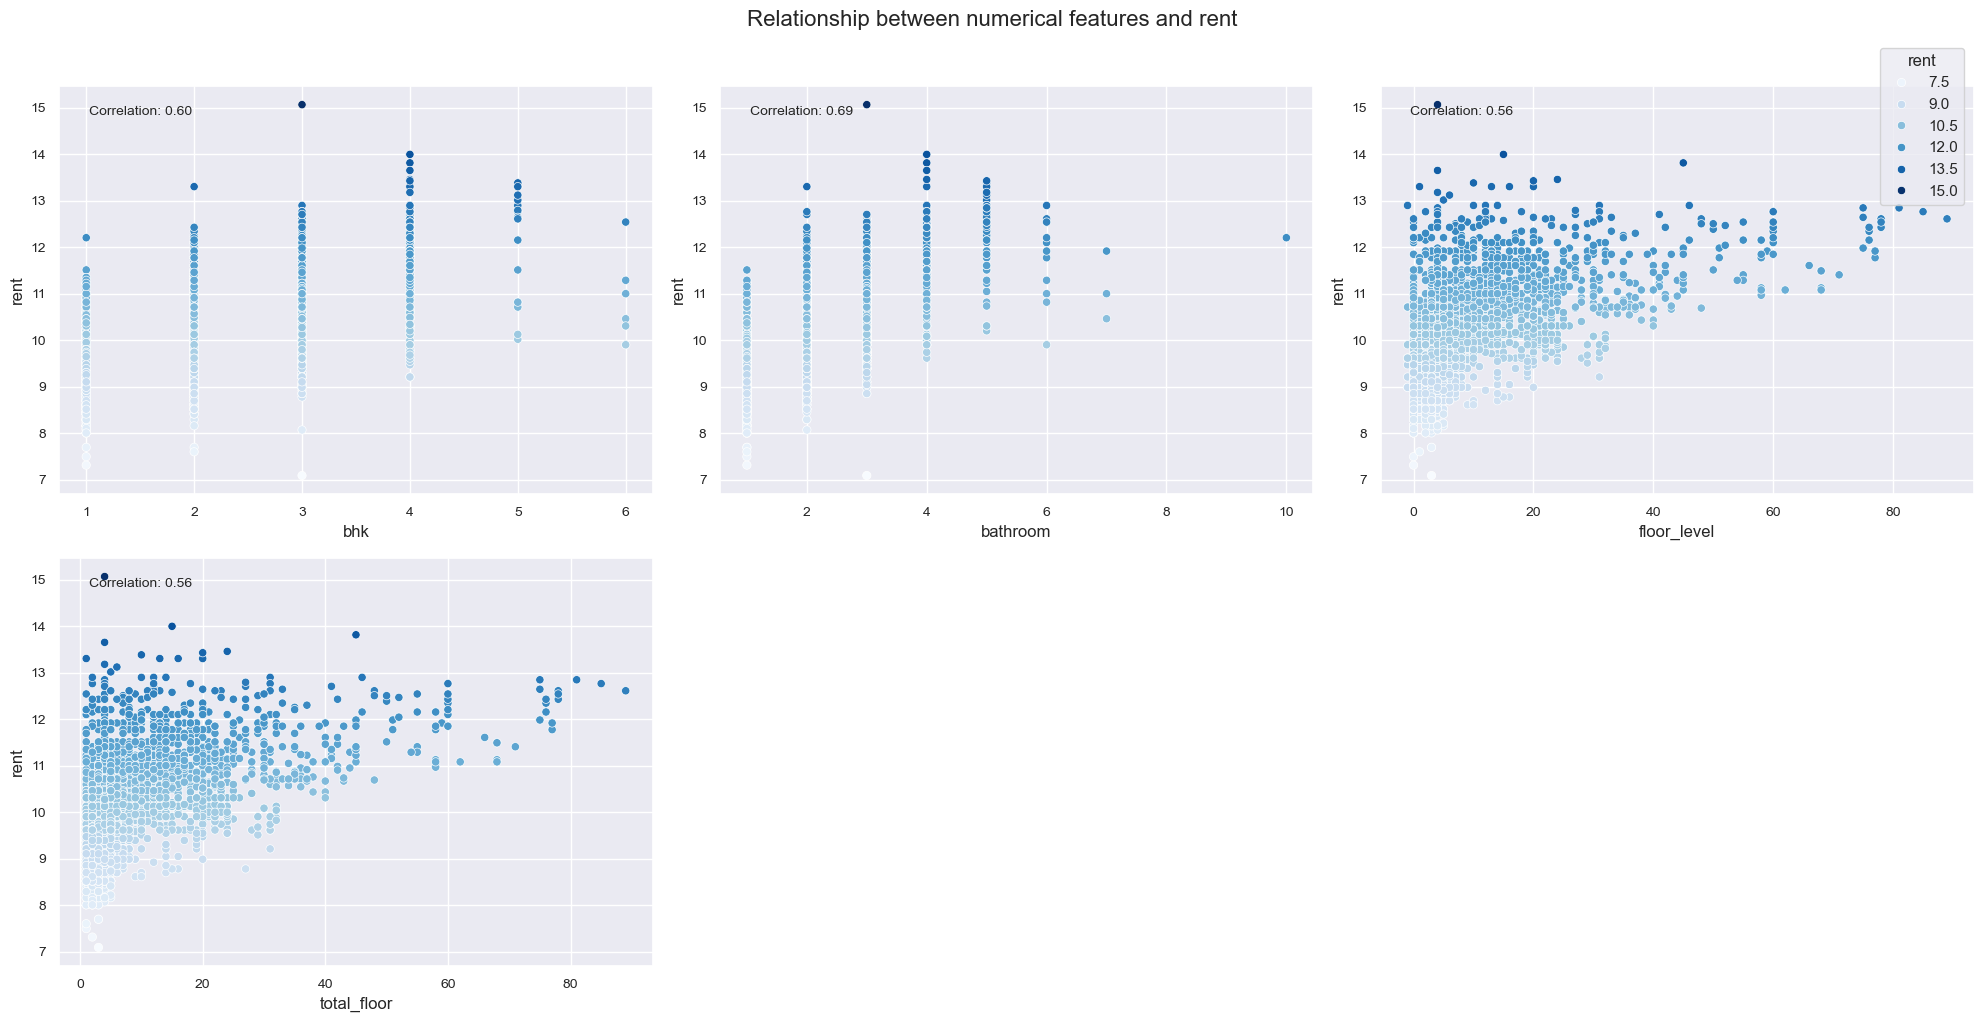

In [163]:
def create_scatter_plots(df, X, num_cols, target):
    n_cols = 3
    n_rows = (len(num_cols) + 3) // 3
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows))
    fig.suptitle(f"Relationship between numerical features and {target}", fontsize=16, y=1.02)
    
    axs = axs.flatten() if n_rows > 1 else axs
    
    for i, col in enumerate(num_cols):
        sns.scatterplot(x=col, y=target, hue=target, palette='Blues', data=df, ax=axs[i])
        
        axs[i].set_xlabel(col, fontsize=12)
        axs[i].set_ylabel(target, fontsize=12)
        
        axs[i].tick_params(axis='both', labelsize=10)
        
        corr = df[col].corr(df[target])
        axs[i].text(0.05, 0.95, f'Correlation: {corr:.2f}', transform=axs[i].transAxes, 
                    verticalalignment='top', fontsize=10)
        
        axs[i].get_legend().remove()
    
    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])
    
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.99, 0.99), title=target)
    
    plt.tight_layout()
    plt.show()

create_scatter_plots(data, None, num_cols, 'rent')

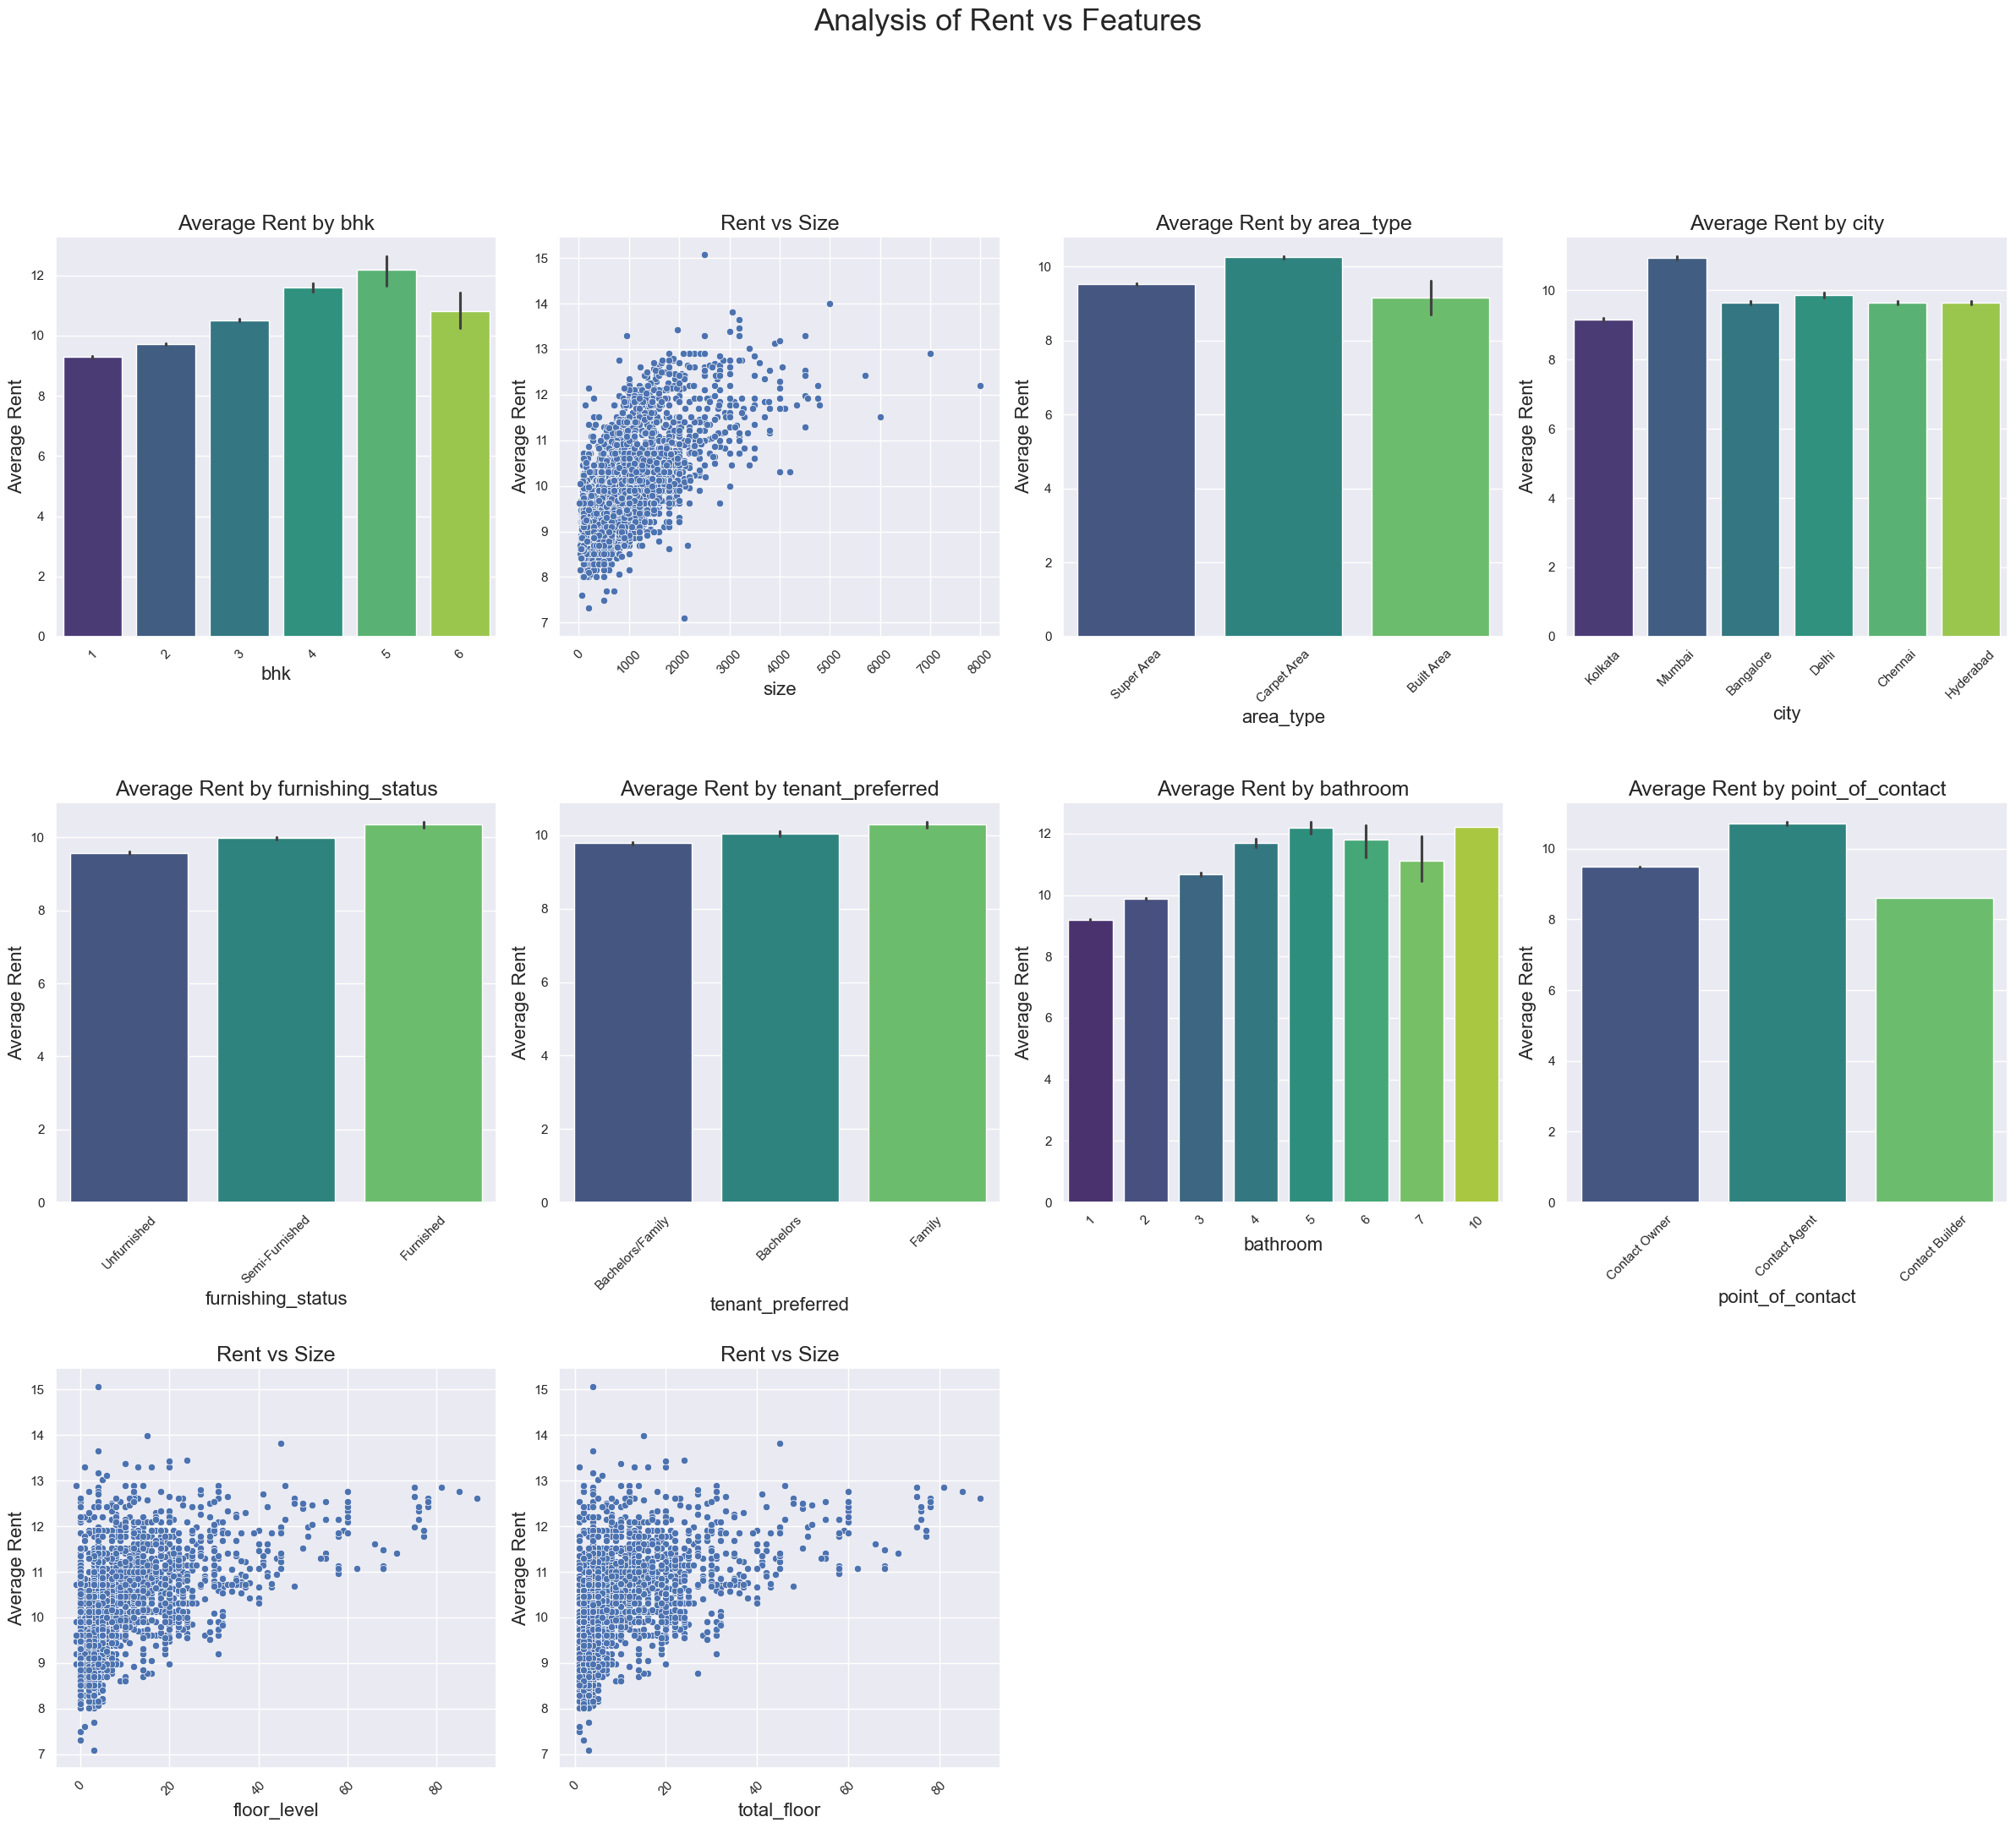

In [179]:
feature_cols = ['bhk','size','area_type','city','furnishing_status','tenant_preferred',
                'bathroom','point_of_contact','floor_level', 'total_floor']

num_rows = (len(feature_cols) + 3) // 4 
fig, axs = plt.subplots(num_rows, 4, figsize=(24, 6 * num_rows))
axs = axs.ravel()

fig.suptitle("Analysis of Rent vs Features", fontsize=26, y=1.2)

for i, col in enumerate(feature_cols):
    ax = axs[i]
    if col in ['bhk','area_type','city','furnishing_status','tenant_preferred','point_of_contact']:
        sns.barplot(x=col, y='rent', data=data, ax=ax, palette='viridis')
        ax.set_title(f'Average Rent by {col}', fontsize=18)
    elif col in ['size','floor_level','total_floor']:
        sns.scatterplot(x=col, y='rent', data=data, ax=ax, palette='Blues')
        ax.set_title('Rent vs Size', fontsize=18)
    elif col in ['bathroom']:
        sns.barplot(x=col, y='rent', data=data, ax=ax, palette='viridis')
        ax.set_title(f'Average Rent by {col}', fontsize=18)

    ax.set_xlabel(col, fontsize=16)
    ax.set_ylabel('Average Rent', fontsize=16)
    ax.tick_params(axis='x', rotation=45)

for j in range(len(feature_cols), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.subplots_adjust(top=1.05)
plt.show()

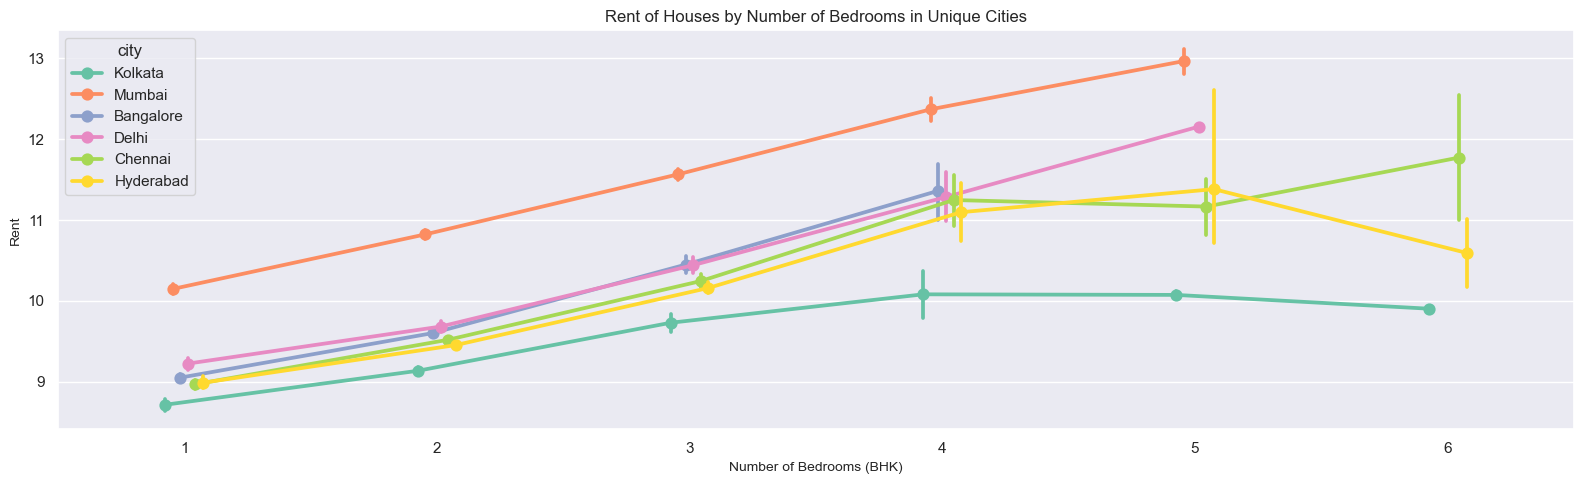

In [183]:
# Visualize average rent of houses by the number of bedrooms (BHK) across different cities
plt.figure(figsize=(16, 5))
sns.pointplot(data=data[['bhk', 'city', 'rent']],
               x='bhk', y='rent',
               hue='city', estimator=np.mean, 
               palette='Set2', dodge=True)

plt.xlabel("Number of Bedrooms (BHK)", fontsize=10)
plt.ylabel("Rent", fontsize=10)
plt.title("Rent of Houses by Number of Bedrooms in Unique Cities", fontsize=12)

plt.tight_layout()
plt.show()

*The plot above indicates that average rent tends to increase with the number of bedrooms. Notably, the average rent for properties with 1BHK configurations appears to exhibit consistent rates across all cities except Mumbai.*

## 3. Data Preprocessing

In [199]:
# Extract Temporal Features 
data['month'] = data['posted_on'].dt.month
data['day'] = data['posted_on'].dt.day
data['week_day'] = data['posted_on'].dt.day_of_week

# drop datetime
data.drop('posted_on',axis=1,inplace=True)
print(data.head())
print(data.columns)

   bhk      rent  size    area_type     city furnishing_status  tenant_preferred  bathroom  \
0    2  9.210440  1100   Super Area  Kolkata       Unfurnished  Bachelors/Family         2   
1    2  9.903538   800   Super Area  Kolkata    Semi-Furnished  Bachelors/Family         1   
2    2  9.741027  1000   Super Area  Kolkata    Semi-Furnished  Bachelors/Family         1   
3    2  9.210440   800   Super Area  Kolkata       Unfurnished  Bachelors/Family         1   
4    2  8.922792   850  Carpet Area  Kolkata       Unfurnished         Bachelors         1   

  point_of_contact  floor_level  total_floor  month  day  week_day  
0    Contact Owner            0            2      5   18         2  
1    Contact Owner            3            3      5   13         4  
2    Contact Owner            3            3      5   16         0  
3    Contact Owner            2            2      7    4         0  
4    Contact Owner            2            2      5    9         0  
Index(['bhk', 'rent',

In [205]:
data['tenant_preferred'] = data['tenant_preferred'].replace(['Bachelors/Family', 'Bachelors', 'Family'],[0,1,2])
data['furnishing_status'] = data['furnishing_status'].replace(['Unfurnished', 'Semi-Furnished', 'Furnished'],[0,1,2])
data['area_type'] = data['area_type'].replace(['Super Area', 'Carpet Area', 'Built Area'],[0,1,2])
data["city"] = data["city"].replace(['Kolkata', 'Mumbai', 'Bangalore', 'Delhi', 'Chennai', 'Hyderabad'],[0,1,2,3,4,5])
data['point_of_contact'] = data['point_of_contact'].replace(['Contact Owner', 'Contact Agent', 'Contact Builder'],[0,1,2])

In [207]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4742 entries, 0 to 4745
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bhk                4742 non-null   int64  
 1   rent               4742 non-null   float64
 2   size               4742 non-null   int64  
 3   area_type          4742 non-null   int64  
 4   city               4742 non-null   int64  
 5   furnishing_status  4742 non-null   int64  
 6   tenant_preferred   4742 non-null   int64  
 7   bathroom           4742 non-null   int64  
 8   point_of_contact   4742 non-null   int64  
 9   floor_level        4742 non-null   int64  
 10  total_floor        4742 non-null   int64  
 11  month              4742 non-null   int32  
 12  day                4742 non-null   int32  
 13  week_day           4742 non-null   int32  
dtypes: float64(1), int32(3), int64(10)
memory usage: 500.1 KB


In [209]:
data.head()

,bhk,rent,size,area_type,city,furnishing_status,tenant_preferred,bathroom,point_of_contact,floor_level,total_floor,month,day,week_day
0,2,9.210440,1100,0,0,0,0,2,0,0,2,5,18,2
1,2,9.903538,800,0,0,1,0,1,0,3,3,5,13,4
2,2,9.741027,1000,0,0,1,0,1,0,3,3,5,16,0
3,2,9.210440,800,0,0,0,0,1,0,2,2,7,4,0
4,2,8.922792,850,1,0,0,1,1,0,2,2,5,9,0


#### Correlation Matrix

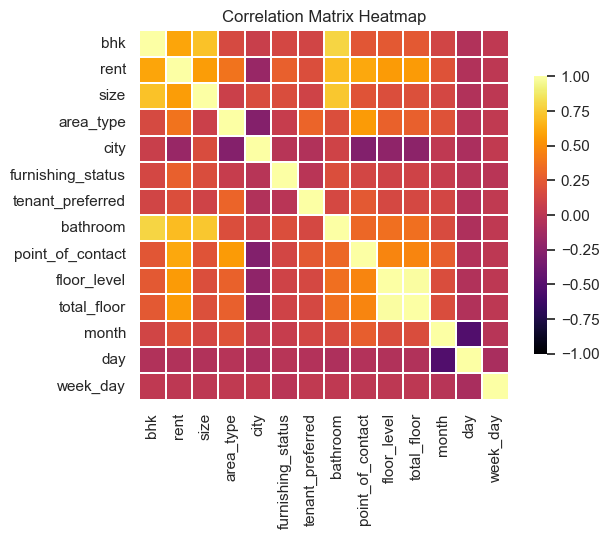

In [211]:
#cmap = sns.diverging_palette(230, 20, as_cmap=True) coolwarm
sns.heatmap(data.corr(), linewidths=0.3, square=True, cmap='inferno', vmax=1, vmin=-1, center=0, cbar_kws={"shrink": .75})
plt.yticks(rotation=0)  
plt.title(f'Correlation Matrix Heatmap', fontsize=12)
plt.show()

In [213]:
# Positive correlations
corr = data.corr()
sol = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
          .stack()
          .sort_values(ascending=False))
corr_df = pd.DataFrame(sol, columns=['corr']).reset_index()
corr_df.columns = ['antecedent', 'consequent', 'correlation']
top_corr = corr_df.head(10000)
print('Top 10 positively correlated features:')
print(top_corr.head(10))

Top 10 positively correlated features:
    antecedent        consequent  correlation
0  floor_level       total_floor     0.990091
1          bhk          bathroom     0.794943
2         size          bathroom     0.740758
3          bhk              size     0.716257
4         rent          bathroom     0.692439
5         rent  point_of_contact     0.615117
6          bhk              rent     0.596724
7         rent              size     0.568067
8         rent       floor_level     0.559350
9    area_type  point_of_contact     0.558411


In [215]:
# Negative correlations
sol = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
          .stack()
          .sort_values(ascending=True))
corrs = pd.DataFrame(sol, columns=['corr']).reset_index()
corrs.columns = ['antecedent', 'consequent', 'correlation']
top_negative_corrs = corrs.head(10000)
print('Top negative correlated features:')
print(top_negative_corrs.head(10))

Top negative correlated features:
    antecedent        consequent  correlation
0        month               day    -0.524455
1         city  point_of_contact    -0.284520
2    area_type              city    -0.277492
3         city       total_floor    -0.236036
4         city       floor_level    -0.226453
5         rent              city    -0.179352
6          day          week_day    -0.089590
7         city               day    -0.080761
8     bathroom               day    -0.066294
9  total_floor               day    -0.054014


In [217]:
# Top feature with correlation to target
apx_corr = corr_df[corr_df.consequent =='rent']
apx_corr.head(10)

,antecedent,consequent,correlation
6,bhk,rent,0.596724


## 4. Data Manipulation

In [275]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel

In [221]:
X = data.drop(['rent'], axis=1)
y = data[['rent']].values

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
y_train = y_train.ravel()
y_test = y_test.ravel()

In [227]:
print(f'Xtrain: {X_train.shape}, Xtext: {X_test.shape}\n ytrain: {y_train.shape}, ytest: {y_test.shape}')

Xtrain: (3177, 13), Xtext: (1565, 13)
 ytrain: (3177,), ytest: (1565,)


## 5. Feature Selection || Extraction

In [229]:
def select_important_features(X, y, estimator):
    feature_selector = SelectFromModel(estimator=estimator).fit(X, y)
    print(f'Selected Feature Threshold = {feature_selector.threshold_}')
    
    selected_features = X.columns[feature_selector.get_support()]
    print(f'Number of Selected Features = {len(selected_features)}')
    
    selected_features_df = pd.DataFrame({
        'Feature': X.columns,
        'Is_Selected': feature_selector.get_support()
    })
    
    selected_features_df = selected_features_df[selected_features_df['Is_Selected']]
    selected_features_df.reset_index(drop=True, inplace=True)
    
    return selected_features_df, selected_features

random_forest_estimator = RandomForestRegressor(random_state=42)
df, selected_feature_names = select_important_features(X_train, y_train, random_forest_estimator)
df

Selected Feature Threshold = 0.07692307692307693
Number of Selected Features = 3


,Feature,Is_Selected
0,size,True
1,bathroom,True
2,point_of_contact,True


In [237]:
gbr_estimator = GradientBoostingRegressor(random_state=42)
df, selected_feature_names = select_important_features(X_train, y_train, gbr_estimator)
df

Selected Feature Threshold = 0.0769230769230769
Number of Selected Features = 5


,Feature,Is_Selected
0,size,True
1,city,True
2,bathroom,True
3,point_of_contact,True
4,floor_level,True


In [285]:
def evaluate_model(model, X_train, X_test, y_train, y_test, parameters=None):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    model_text_list=[]; metric_list=[]; score_list=[] ; param_list=[]
    
    metrics_data = {
        'Model': [],
        'Parameters': [],
        'Metric': [],
        'Score': []
    }

    metrics = [
        (r2_score, 'R_Squared'),
        (lambda y_true, y_pred: 1 - (1 - r2_score(y_true, y_pred)) * (len(y_true) - 1) / (len(y_true) - X_train.shape[1] - 1), 'Adjusted_R_Squared'),
        (mean_squared_error, 'MSE'),
        (lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False), 'RMSE'),
        (mean_absolute_error, 'MAE')
    ]

    for metric_func, metric_name in metrics:
        score = metric_func(y_test, predictions)
        metrics_data['Model'].append(type(model).__name__)
        metrics_data['Parameters'].append(parameters)
        metrics_data['Metric'].append(metric_name)
        metrics_data['Score'].append(score)

    return pd.DataFrame(metrics_data)

In [277]:
def optimize_model_params(param_grid, model, X_train, y_train):
    grid_search = HalvingGridSearchCV(
        model,
        param_grid,
        cv=10,
        scoring='neg_mean_absolute_error',
        min_resources="smallest",
        random_state=42
    ).fit(X_train, y_train)
    
    print("Best Estimator:", grid_search.best_estimator_)
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score (Negative MAE):", grid_search.best_score_)
    
    return grid_search.best_estimator_, grid_search.best_params_

In [255]:
def cross_validate_model(model, X, y):
    # drop na columns
    X_cleaned = X.dropna(axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size=0.2, random_state=42)
    
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
    
    avg_score = scores.mean() ;
    std_dev = scores.std()
    
    print(f"Average Negative MAE: {avg_score:.4f}, Std: {std_dev:.4f}")
    return avg_score

In [269]:
cv_model = GradientBoostingRegressor(random_state=42)

print("Evaluating GBR model with normalization and standardization...\n")

# Normalization
normalized_X = (X - X.min()) / (X.max() - X.min())
norm_score = cross_validate_model(cv_model, normalized_X, y)
print(f"Normalized Model Score (MAE): {norm_score:.4f}")

# Standardization
standardized_X = (X - X.mean()) / X.std()
std_score = cross_validate_model(cv_model, standardized_X, y)
print(f"Standardized Model Score (MAE): {std_score:.4f}")

# Choose better method based on scores
if norm_score > std_score:
    print(f"Normalization is better with a score of {norm_score:.4f} > {std_score:.4f}")
    X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.2, random_state=42)
else:
    print(f"Standardization is better with a score of {std_score:.4f} > {norm_score:.4f}")
    X_train, X_test, y_train, y_test = train_test_split(standardized_X, y, test_size=0.2, random_state=42)


Evaluating GBR model with normalization and standardization...

Average Negative MAE: -0.2936, Std: 0.0122
Normalized Model Score (MAE): -0.2936
Average Negative MAE: -0.2937, Std: 0.0122
Standardized Model Score (MAE): -0.2937
Normalization is better with a score of -0.2936 > -0.2937


In [259]:
cv_model2 = RandomForestRegressor(random_state=42)

print("Evaluating Random Forest model with normalization and standardization...\n")

# Normalization
normalized_X = (X - X.min()) / (X.max() - X.min())
norm_score = cross_validate_model(cv_model2, normalized_X, y)
print(f"Normalized Model Score (MAE): {norm_score:.4f}")

# Standardization
standardized_X = (X - X.mean()) / X.std()
std_score = cross_validate_model(cv_model2, standardized_X, y)
print(f"Standardized Model Score (MAE): {std_score:.4f}")

# Choose better method based on scores
if norm_score > std_score:
    print(f"Normalization is better with a score of {norm_score:.4f} > {std_score:.4f}")
    X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.2, random_state=42)
else:
    print(f"Standardization is better with a score of {std_score:.4f} > {norm_score:.4f}")
    X_train, X_test, y_train, y_test = train_test_split(standardized_X, y, test_size=0.2, random_state=42)

Evaluating Random Forest model with normalization and standardization...

Average Negative MAE: -0.3009, Std: 0.0146
Normalized Model Score (MAE): -0.3009
Average Negative MAE: -0.3011, Std: 0.0142
Standardized Model Score (MAE): -0.3011
Normalization is better with a score of -0.3009 > -0.3011


## 6. Predictive Modeling

In [267]:
# Linear Regression
model = LinearRegression()
LinearRegression_test = evaluate_model(model, X_train, X_test, y_train, y_test)
LinearRegression_test

,Model,Parameters,Metric,Score
0,LinearRegression,None,R_Squared,0.742386
1,LinearRegression,None,Adjusted_R_Squared,0.738805
2,LinearRegression,None,MSE,0.228287
3,LinearRegression,None,RMSE,0.477794
4,LinearRegression,None,MAE,0.360092


In [279]:
param_rf_grid = {'n_estimators': [10,50,100,200,300],'min_samples_leaf':[1,2,3]}
rf_model = RandomForestRegressor(random_state=42)
best_rf_est, best_param_rf = optimize_model_params(param_rf_grid, rf_model, X_train, y_train)

rf_test = evaluate_model(best_rf_est, X_train, X_test, y_train, y_test, best_param_rf)
rf_test

Best Estimator: RandomForestRegressor(n_estimators=50, random_state=42)
Best Parameters: {'min_samples_leaf': 1, 'n_estimators': 50}
Best Score (Negative MAE): -0.3739224198074354


,Model,Parameters,Metric,Score
0,RandomForestRegressor,"{'min_samples_leaf': 1, 'n_estimators': 50}",R_Squared,0.820491
1,RandomForestRegressor,"{'min_samples_leaf': 1, 'n_estimators': 50}",Adjusted_R_Squared,0.817995
2,RandomForestRegressor,"{'min_samples_leaf': 1, 'n_estimators': 50}",MSE,0.159074
3,RandomForestRegressor,"{'min_samples_leaf': 1, 'n_estimators': 50}",RMSE,0.398841
4,RandomForestRegressor,"{'min_samples_leaf': 1, 'n_estimators': 50}",MAE,0.295050


In [280]:
param_gb_grid = {
    'n_estimators': [50, 100, 200], 
    'learning_rate': [0.01, 0.1, 0.2], 
    'max_depth': [3, 5, 7],  
    'min_samples_split': [2, 5, 10] 
}
gb_model = GradientBoostingRegressor(random_state=42) 
best_gb_est, best_param_gb = optimize_model_params(param_gb_grid, gb_model, X_train, y_train)

# Test predictions with the best estimator
gb_test = evaluate_model(best_gb_est, X_train, X_test, y_train, y_test, best_param_gb)
gb_test

Best Estimator: GradientBoostingRegressor(min_samples_split=5, random_state=42)
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}
Best Score (Negative MAE): -0.29736260298151695


,Model,Parameters,Metric,Score
0,GradientBoostingRegressor,"{'learning_rate': 0.1, 'max_depth': 3, 'min_sa...",R_Squared,0.822629
1,GradientBoostingRegressor,"{'learning_rate': 0.1, 'max_depth': 3, 'min_sa...",Adjusted_R_Squared,0.820163
2,GradientBoostingRegressor,"{'learning_rate': 0.1, 'max_depth': 3, 'min_sa...",MSE,0.157179
3,GradientBoostingRegressor,"{'learning_rate': 0.1, 'max_depth': 3, 'min_sa...",RMSE,0.396458
4,GradientBoostingRegressor,"{'learning_rate': 0.1, 'max_depth': 3, 'min_sa...",MAE,0.295863


Best model for Adjusted_R_Squared: GradientBoostingRegressor
Best model for MAE: RandomForestRegressor
Best model for MSE: GradientBoostingRegressor
Best model for RMSE: GradientBoostingRegressor
Best model for R_Squared: GradientBoostingRegressor


Metric,Model,Adjusted_R_Squared,MAE,MSE,RMSE,R_Squared
0,LinearRegression,0.738805,0.360092,0.228287,0.477794,0.742386
0,RandomForestRegressor,0.817995,0.295050,0.159074,0.398841,0.820491
0,GradientBoostingRegressor,0.820163,0.295863,0.157179,0.396458,0.822629


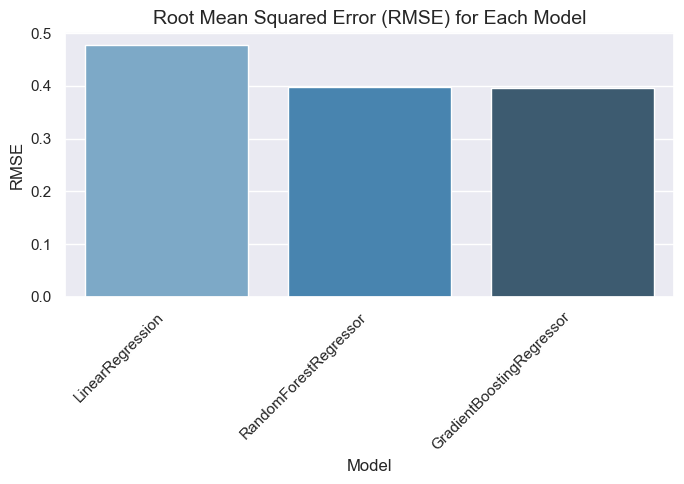

In [302]:
def evaluate_and_rank_models(test_results_list):
    pivoted_results = []

    for result in test_results_list:
        pivoted_results.append(result.pivot(index='Model', columns='Metric', values='Score').reset_index())

    combined_results = pd.concat(pivoted_results)

    for metric in combined_results.columns.values:
        if metric != 'Model':
            if metric == 'Adjusted_R_Squared' or metric == 'R_Squared':
                best_model = combined_results[combined_results[metric]==combined_results[metric].max()].Model.values[0]
                print(f"Best model for {metric}: {best_model}")
            else:
                best_model = combined_results[combined_results[metric]==combined_results[metric].min()].Model.values[0]
                print(f"Best model for {metric}: {best_model}")
        else:
            pass
    
    display(combined_results)
    
    plt.figure(figsize=(7, 5))
    sns.barplot(x=combined_results['Model'], y=combined_results['RMSE'], palette='Blues_d')
    plt.xlabel('Model', fontsize=8)
    plt.ylabel('RMSE', fontsize=8)
    plt.title('Root Mean Squared Error (RMSE) for Each Model', fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return combined_results

test_results = [LinearRegression_test, rf_test, gb_test]
final_results = evaluate_and_rank_models(test_results)

#### Model Evaluation Results

**Best Model by Metrics:**

- **Adjusted R-Squared**: GradientBoostingRegressor
- **R-Squared**: GradientBoostingRegressor
- **MSE**: GradientBoostingRegressor
- **RMSE**: GradientBoostingRegressor
- **MAE**: RandomForestRegressor

**Key Insights:**

- **GradientBoostingRegressor** performed best in terms of overall predictive accuracy (Adjusted R-Squared, R-Squared, MSE, and RMSE).
- **RandomForestRegressor** performed slightly better in terms of Mean Absolute Error (MAE), which focuses on minimizing absolute differences between predicted and actual values, though the difference is quite small.

**Conclusion**

Since **GradientBoostingRegressor** and **RandomForestRegressor** have similar metric values, our final model will be a combination of both models


In [313]:
def create_combined_model(X_train, y_train):
    rf_model = RandomForestRegressor(n_estimators=50, min_samples_leaf=1, random_state=42)
    gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_split=5, random_state=42)
    
    rf_model.fit(X_train, y_train)
    gb_model.fit(X_train, y_train)
    
    return rf_model, gb_model

In [315]:
def predict_combined(rf_model, gb_model, X):
    rf_predictions = rf_model.predict(X)
    gb_predictions = gb_model.predict(X)
    return (rf_predictions + gb_predictions) / 2

In [317]:
# Create and train the combined model
rf_model, gb_model = create_combined_model(X_train, y_train)

In [319]:
combined_predictions = predict_combined(rf_model, gb_model, X_test)
rmse = np.sqrt(mean_squared_error(y_test, combined_predictions))
r2 = r2_score(y_test, combined_predictions)

print(f"Combined Model RMSE: {rmse}")
print(f"Combined Model R²: {r2}")

Combined Model RMSE: 0.3878559705290697
Combined Model R²: 0.8302428872869847


## 7. Deployment

In [321]:
import pickle

model_filename = 'arko_combined_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump({"RandomForest": rf_model, "GradientBoosting": gb_model}, file)

print(f"Combined model exported as {model_filename}")

Combined model exported as arko_combined_model.pkl


In [323]:
# Function to make predictions using the exported model
def predict_rent(model_filename, input_data):
    with open(model_filename, 'rb') as file:
        models = pickle.load(file)
    
    rf_model = models["RandomForest"]
    gb_model = models["GradientBoosting"]
    
    return predict_combined(rf_model, gb_model, input_data)


In [327]:
sample_input = np.array([[2, 1000, 0, 1, 1, 0, 2, 0, 2, 2, 5, 15, 2]])
predicted_rent = predict_rent(model_filename, sample_input)
print(f"Predicted Rent: {np.expm1(predicted_rent[0])}")  # Convert back from log scale

Predicted Rent: 52161.70653720221


In [334]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout

with open('arko_combined_model.pkl', 'rb') as file:
    model_data = pickle.load(file)

rf_model = model_data["RandomForest"]
gb_model = model_data["GradientBoosting"]

In [336]:
# Create widgets for user input
bhk = widgets.IntSlider(value=2, min=1, max=10, step=1, description='BHK:')
size = widgets.IntSlider(value=1000, min=100, max=10000, step=100, description='Size (sqft):')
area_type = widgets.Dropdown(options=[('Super Area', 0), ('Carpet Area', 1), ('Built Area', 2)], description='Area Type:')
city = widgets.Dropdown(options=[('Kolkata', 0), ('Mumbai', 1), ('Bangalore', 2), ('Delhi', 3), ('Chennai', 4), ('Hyderabad', 5)], description='City:')
furnishing_status = widgets.Dropdown(options=[('Unfurnished', 0), ('Semi-Furnished', 1), ('Furnished', 2)], description='Furnishing:')
tenant_preferred = widgets.Dropdown(options=[('Bachelors/Family', 0), ('Bachelors', 1), ('Family', 2)], description='Tenant:')
bathroom = widgets.IntSlider(value=2, min=1, max=10, step=1, description='Bathrooms:')
point_of_contact = widgets.Dropdown(options=[('Contact Owner', 0), ('Contact Agent', 1), ('Contact Builder', 2)], description='Contact:')
floor_level = widgets.IntSlider(value=2, min=0, max=50, step=1, description='Floor Level:')
total_floor = widgets.IntSlider(value=5, min=1, max=50, step=1, description='Total Floors:')
month = widgets.IntSlider(value=6, min=1, max=12, step=1, description='Month:')
day = widgets.IntSlider(value=15, min=1, max=31, step=1, description='Day:')
week_day = widgets.IntSlider(value=3, min=0, max=6, step=1, description='Week Day:')

output = widgets.Output()

In [338]:
def on_predict_button_clicked(b):
    with output:
        output.clear_output()
        input_data = np.array([[
            bhk.value, size.value, area_type.value, city.value,
            furnishing_status.value, tenant_preferred.value, bathroom.value,
            point_of_contact.value, floor_level.value, total_floor.value,
            month.value, day.value, week_day.value
        ]])
        predicted_rent = predict_combined(rf_model, gb_model, input_data)
        print(f"Predicted Rent: ₹{np.expm1(predicted_rent[0]):,.2f}")


In [340]:
predict_button = widgets.Button(description="Predict Rent")
predict_button.on_click(on_predict_button_clicked)

In [342]:
# Layout
input_widgets = [bhk, size, area_type, city, furnishing_status, tenant_preferred, 
                 bathroom, point_of_contact, floor_level, total_floor, month, day, week_day]
left_column = VBox(input_widgets[:7], layout=Layout(width='50%'))
right_column = VBox(input_widgets[7:], layout=Layout(width='50%'))
ui = VBox([
    HBox([left_column, right_column]),
    predict_button,
    output
])

display(ui)